In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import math
from google.colab import files
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode


from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC

In [2]:
uploaded = files.upload()
df = pd.read_csv('data_rev.csv')

Saving data_rev.csv to data_rev.csv


In [3]:
df.head()

,Time,FR_t0,FR_t1,FR_t2,FL_t0,FL_t1,FL_t2,RL_t0,RL_t1,RL_t2,...,RR_q1,RR_q2,gyro_0,gyro_1,gyro_2,acc_0,acc_1,acc_2,foot_distance,class
0,0.225720,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,-426.000,1
1,0.235938,4.27734,1.62891,10.42580,-0.070310,-1.77734,2.92969,-3.08984,2.79297,11.09380,...,1.06498,-2.02964,0.05312,0.157877,0.018636,0.530316,-1.154010,12.18410,-232.673,1
2,0.265555,4.27734,1.62891,10.42580,-0.070310,-1.77734,2.92969,-3.08984,2.79297,11.09380,...,1.06498,-2.02964,0.05312,0.157877,0.018636,0.530316,-1.154010,12.18410,-232.673,1
3,0.276117,2.89062,2.17578,9.75781,0.246094,-1.62891,4.04297,-3.33594,3.18750,9.16406,...,1.02296,-2.09864,-0.05234,-0.014700,-0.035690,0.921768,0.667982,6.39132,-219.060,1
4,0.286484,2.89062,2.17578,9.75781,0.246094,-1.62891,4.04297,-3.33594,3.18750,9.16406,...,1.02296,-2.09864,-0.05234,-0.014700,-0.035690,0.921768,0.667982,6.39132,-219.060,1


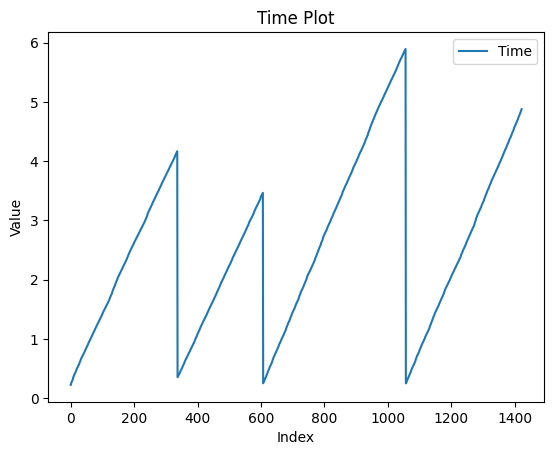

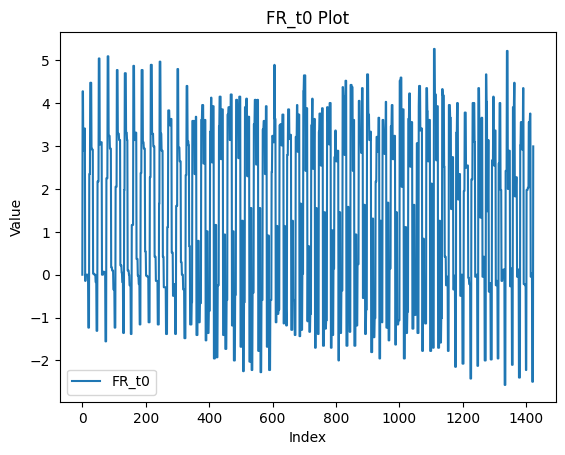

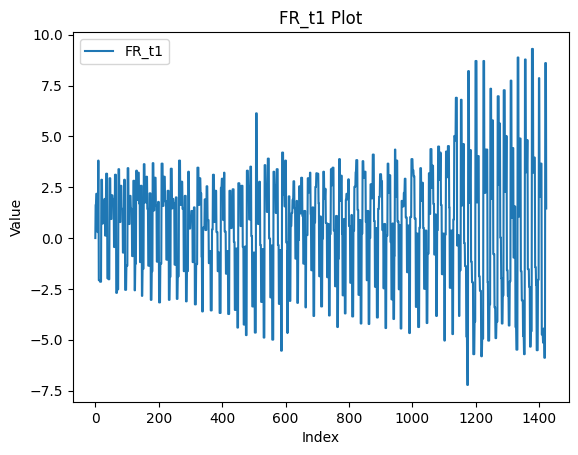

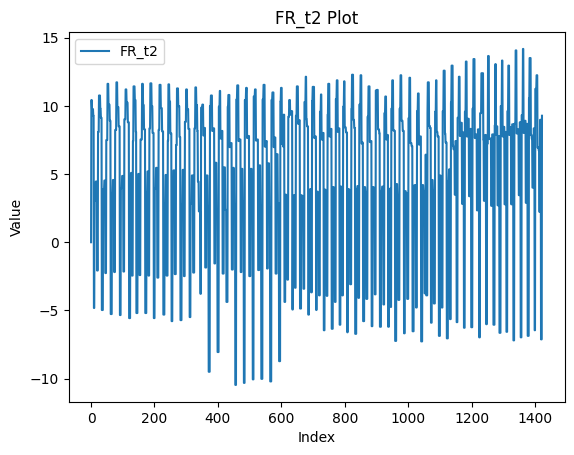

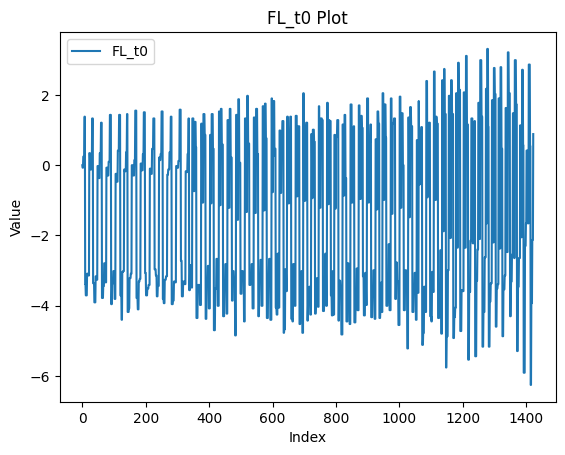

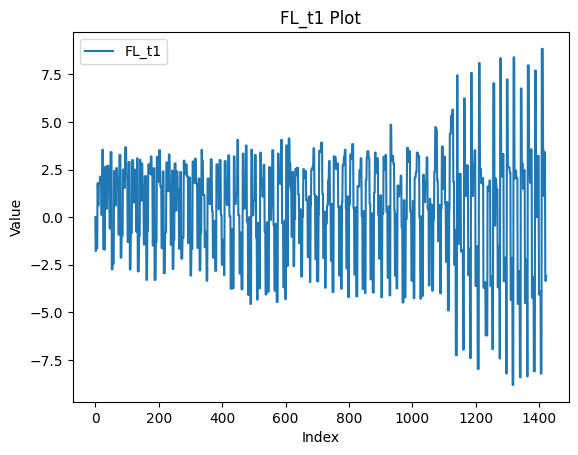

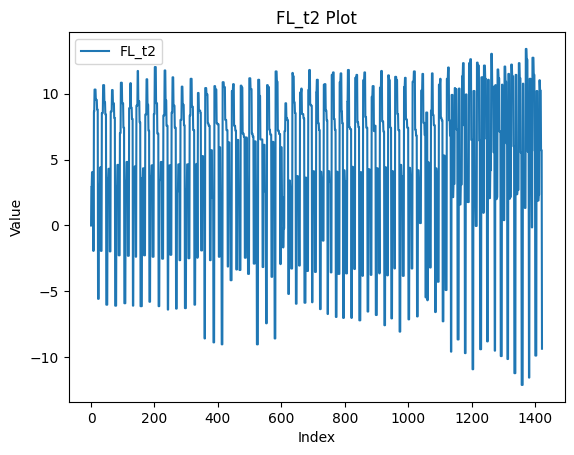

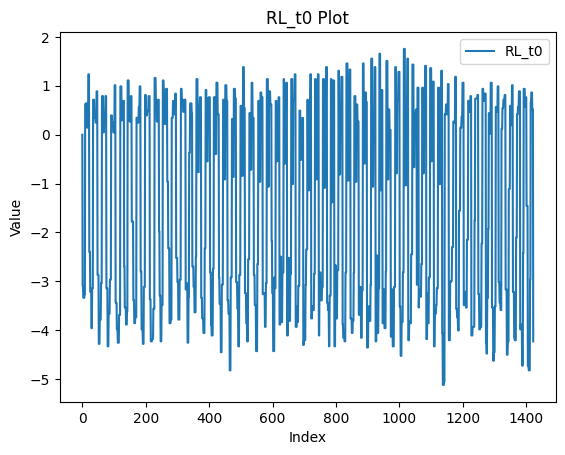

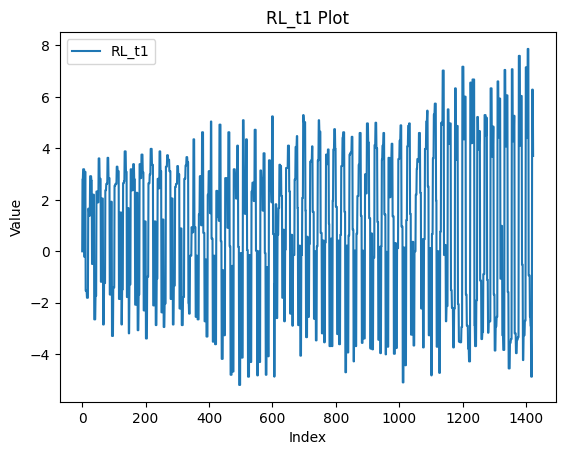

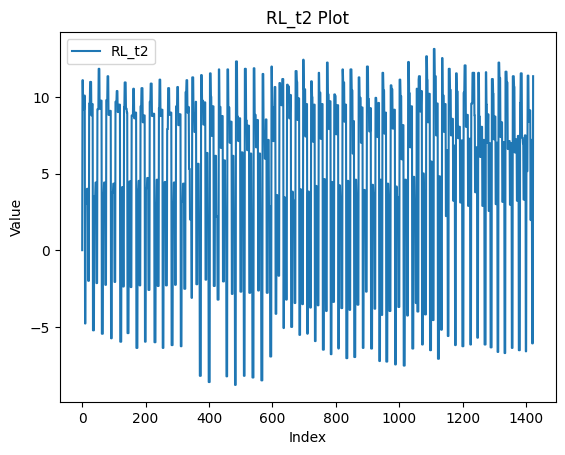

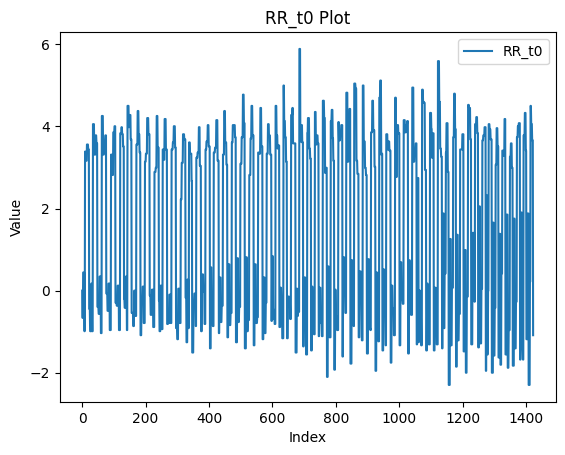

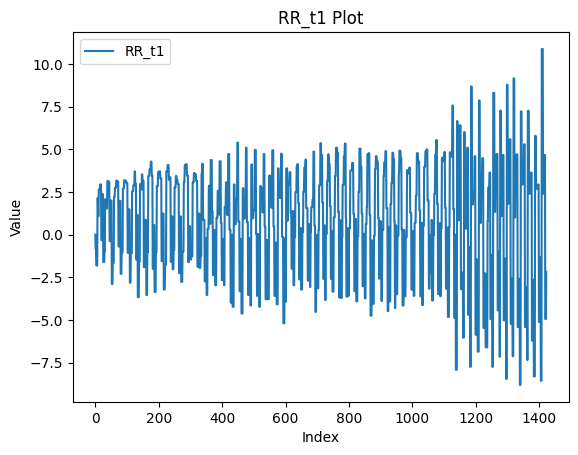

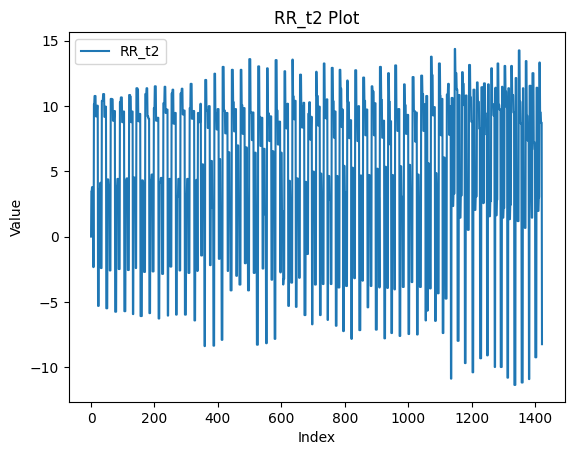

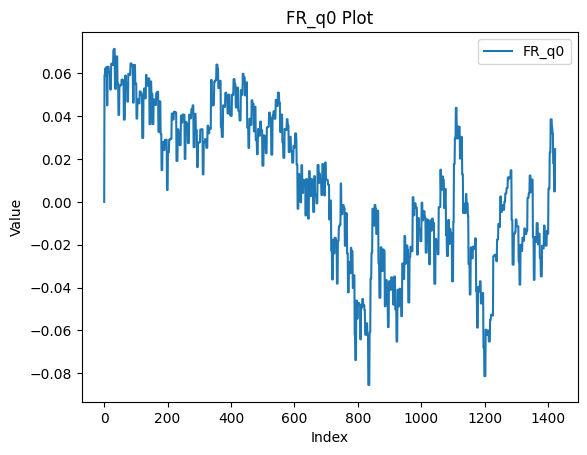

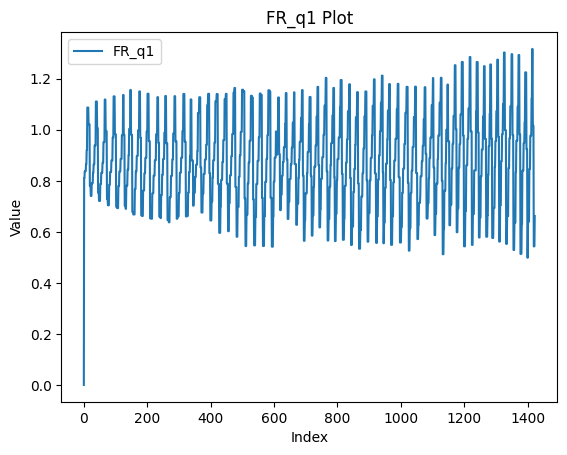

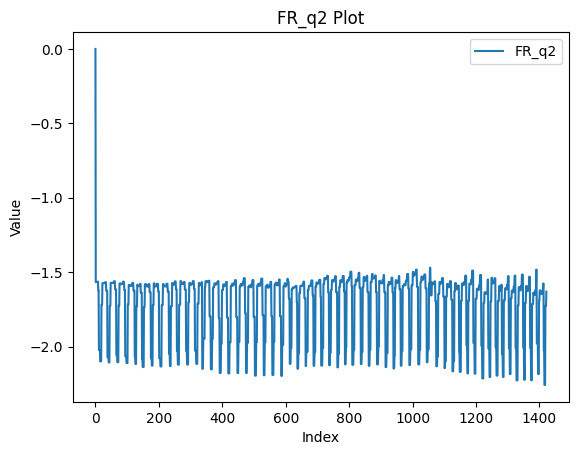

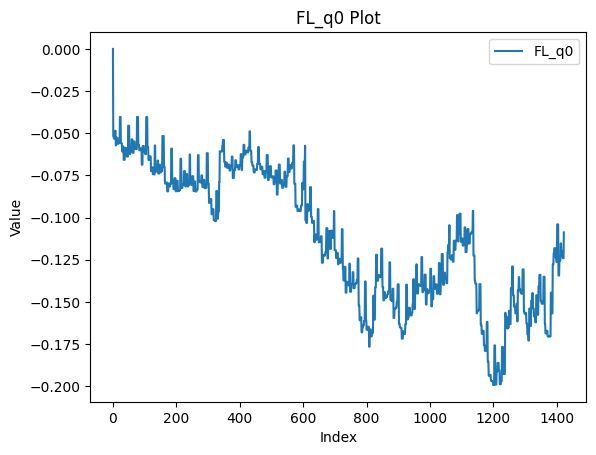

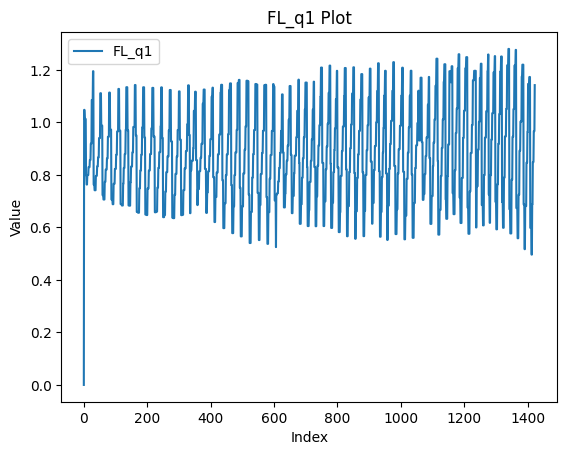

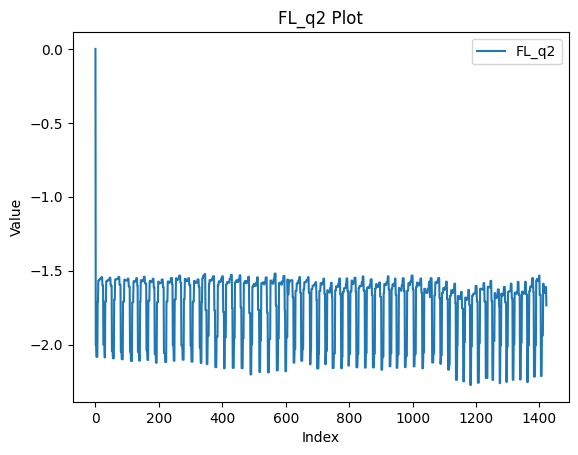

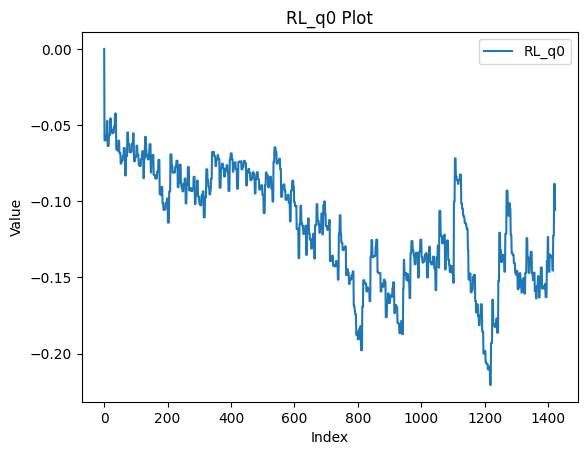

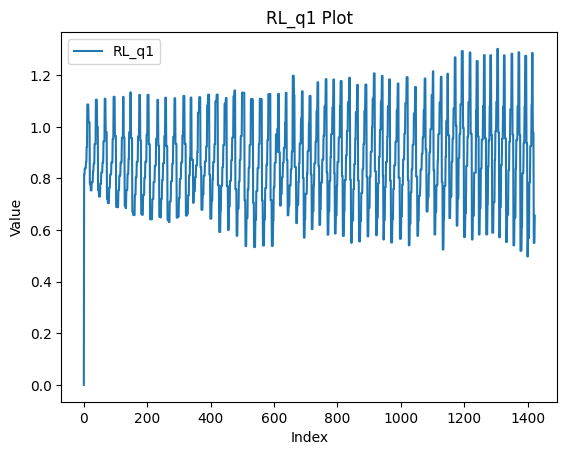

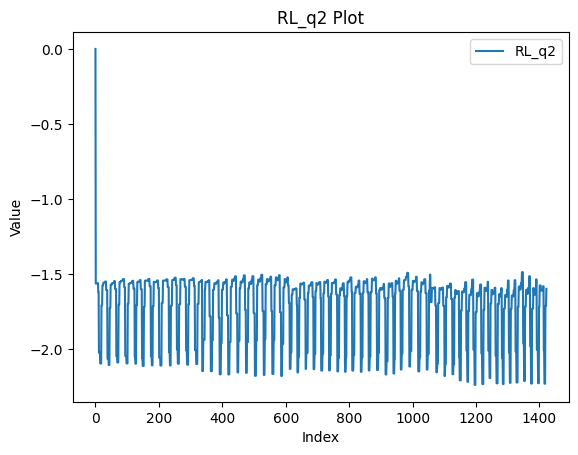

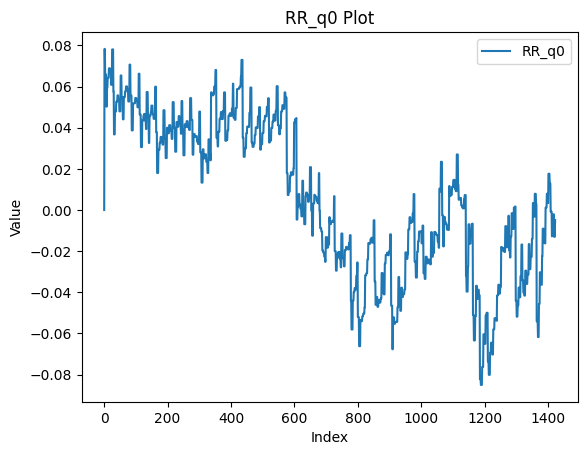

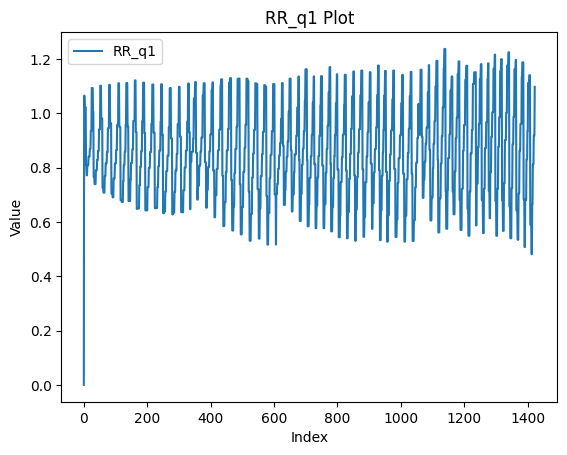

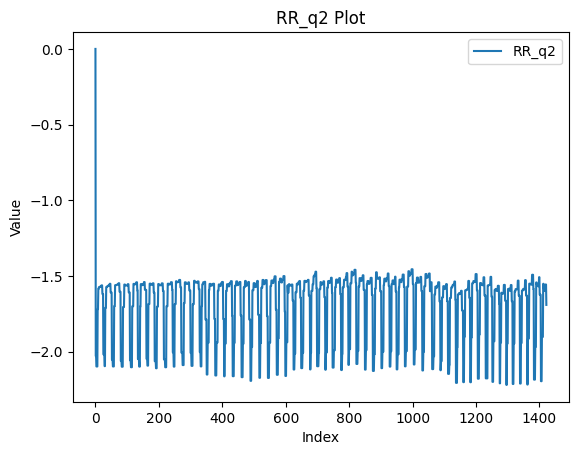

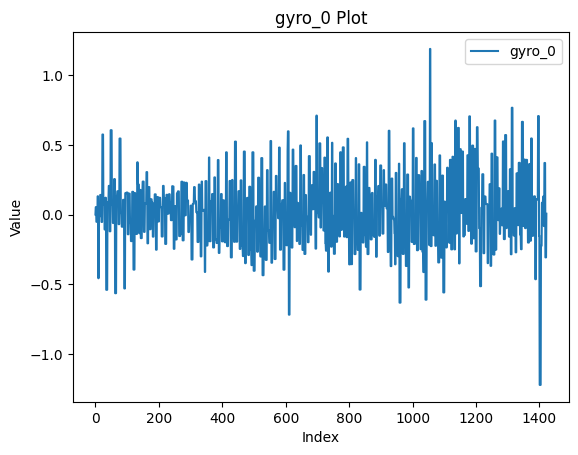

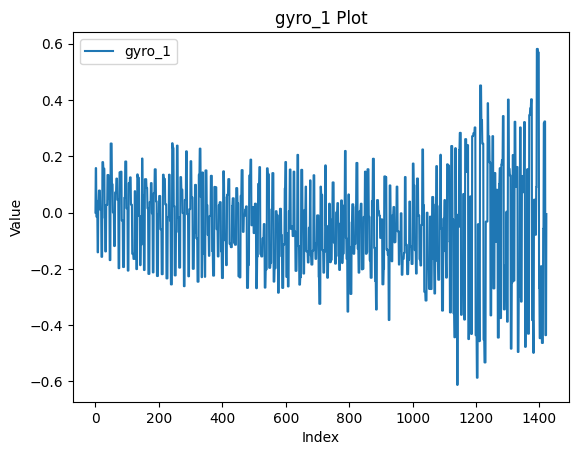

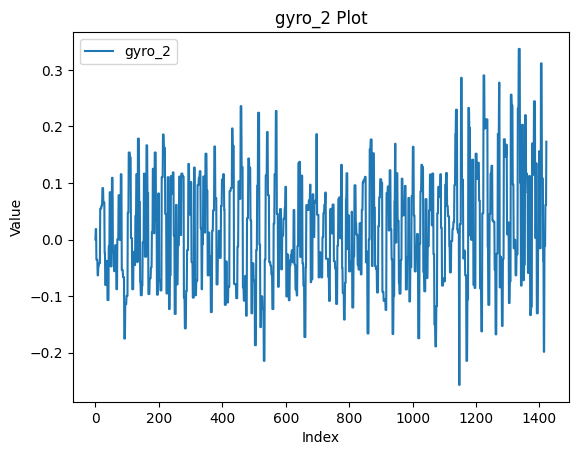

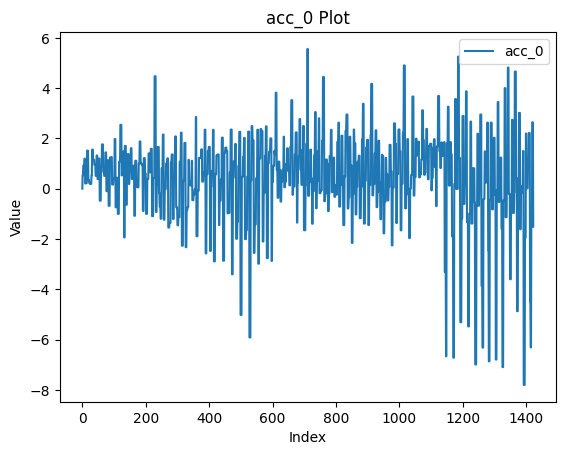

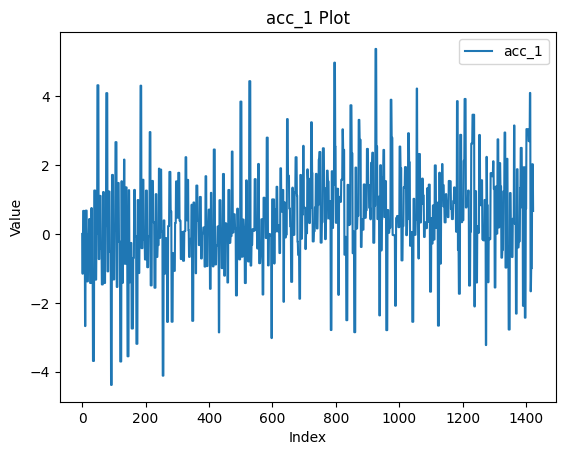

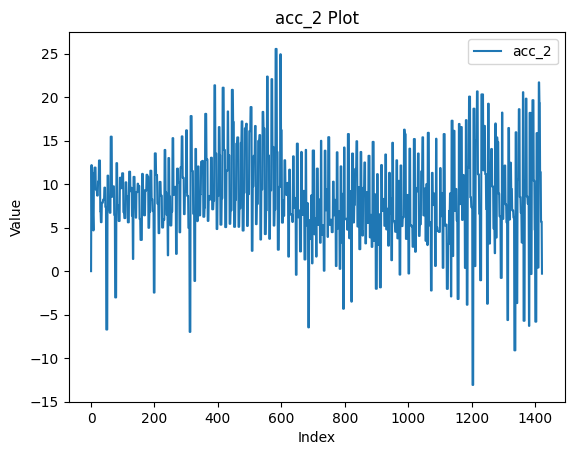

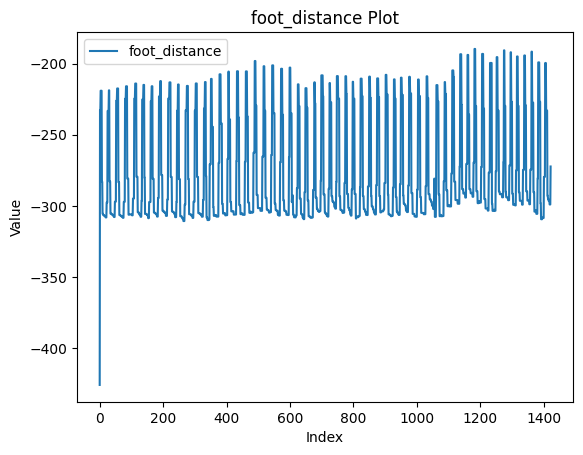

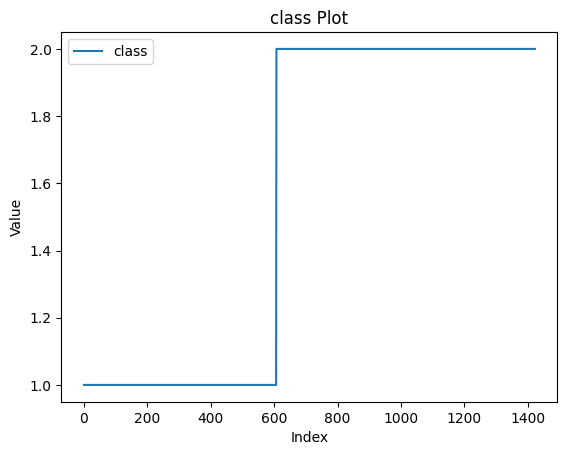

In [4]:
for column in df.columns:
    plt.figure()  # Create a new figure for each plot
    #plt.plot(df[column].iloc[400:800], label=column)  # Plot the rows from 400 to 800
    plt.plot(df[column], label=column)
    plt.title(f'{column} Plot')  # Set the title of the plot
    plt.xlabel('Index')  # Set the x-axis label
    plt.ylabel('Value')  # Set the y-axis label
    plt.legend()  # Display the legend
    plt.show()  # Display the plot


In [5]:
scaler = MinMaxScaler()

# Normalize the DataFrame
normalized_data = scaler.fit_transform(df)

# Convert the normalized data back into a DataFrame with the same column names
df = pd.DataFrame(normalized_data, columns=df.columns)

# Print the normalized DataFrame
print(df)


          Time     FR_t0     FR_t1     FR_t2     FL_t0     FL_t1     FL_t2  \
0     0.000000  0.328016  0.437116  0.424674  0.653877  0.499336  0.474484   
1     0.001802  0.873878  0.535698  0.847922  0.646531  0.398538  0.589427   
2     0.007027  0.873878  0.535698  0.847922  0.646531  0.398538  0.589427   
3     0.008890  0.696909  0.568794  0.820804  0.679592  0.406956  0.633105   
4     0.010719  0.696909  0.568794  0.820804  0.679592  0.406956  0.633105   
...        ...       ...       ...       ...       ...       ...       ...   
1418  0.809626  0.331007  0.080851  0.789089  0.243265  0.692734  0.876171   
1419  0.812978  0.009472  0.957920  0.135584  0.431837  0.310146  0.698546   
1420  0.814867  0.009472  0.957920  0.135584  0.431837  0.310146  0.698546   
1421  0.818300  0.009472  0.957920  0.135584  0.431837  0.310146  0.698546   
1422  0.820570  0.709871  0.525296  0.801141  0.746531  0.324103  0.107741   

         RL_t0     RL_t1     RL_t2  ...     RR_q1     RR_q2    

In [6]:
# We need function Load_data to read data and separate X and label
# to be used in the section below

def load_data(df):
  Y = df.iloc[:, -1]  # Select the last column

 # X = df.iloc[:, selected_columns]
  X = df.iloc[:, 1:-2]
  return X, Y
X, Y = load_data(df)


In [7]:
def batches(X, Y, batch_size, step_size):
    x = []
    y = []
    n = int(math.floor((len(X) - batch_size) / step_size + 1))
    for i in range(n):
        batch = X[i * step_size:i * step_size + batch_size]
        label = Y[i * step_size:i * step_size + batch_size]

        # Extract the mode of the labels
        batch_mode = mode(label).mode
        y.append(batch_mode)
        x.append(batch)

    x = np.array(x)
    y = np.array(y)

    return x, y

# Example usage (replace X and Y with actual data)
X, Y = batches(X, Y, 10, 5)


In [12]:
# we used this part for a usual train-val-test split of data.
# for the final iteration, where we used cross-val, we dont need this cell
#however, we used it and kept it for the GRU model, (last cell)
# need X and Y from previous function
test_size = 0.2
validation_size = 0.2 #example
def split_datasets(X,Y, test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    test_size: [0, 1] indicating percentage of data set to allocate to test split
    validation_size: [0, 1] indicating percentage of data set to allocate to validation split"""

    relative_val_size = validation_size/(1-test_size)

    # create train, validation and test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=relative_val_size)

    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = split_datasets(X,Y, test_size, validation_size)


Training Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5242 - auc: 0.5111 - loss: 0.6907 - precision: 0.5520 - recall: 0.8447 - val_accuracy: 0.5789 - val_auc: 0.9880 - val_loss: 0.6836 - val_precision: 0.5789 - val_recall: 1.0000
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6618 - auc: 0.7680 - loss: 0.6813 - precision: 0.6368 - recall: 0.9572 - val_accuracy: 0.6140 - val_auc: 0.9823 - val_loss: 0.6804 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6770 - auc: 0.6792 - loss: 0.6830 - precision: 0.6557 - recall: 0.9577 - val_accuracy: 0.6140 - val_auc: 0.9912 - val_loss: 0.6764 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6519 - auc: 0.8307 - loss: 0.6767 - precision: 0.6285 - recall: 0.9871 - val_accuracy: 0.5789 - val_auc: 0.9943 - val_loss: 0.6712 - val_precision: 0.5789 - val_recall: 1.0000
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s

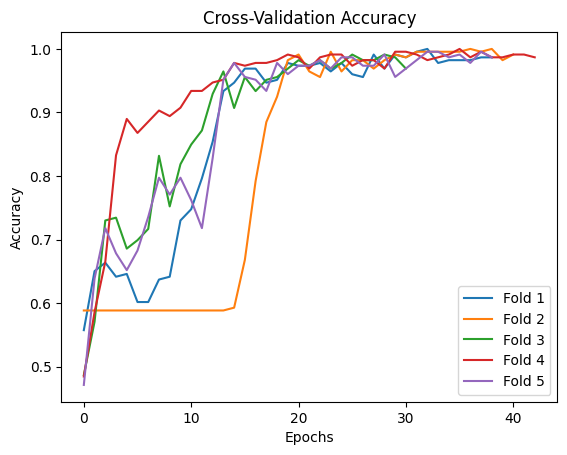

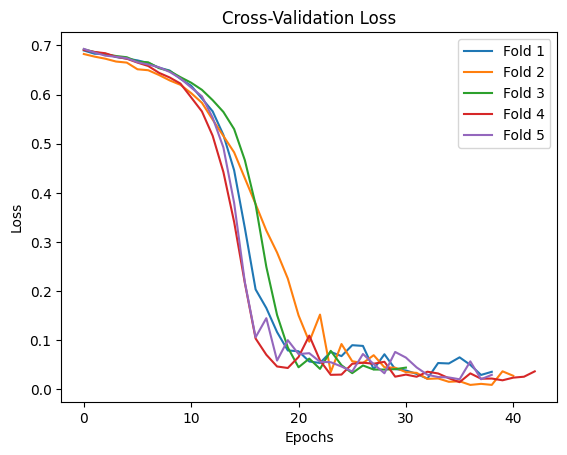

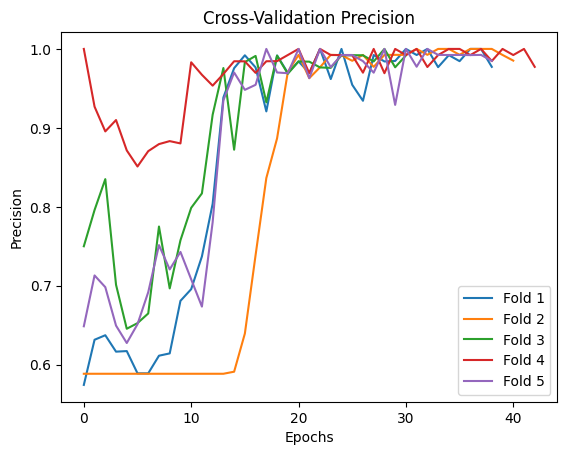

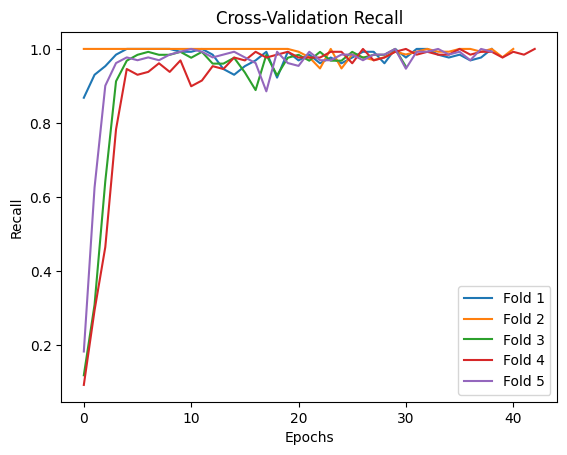

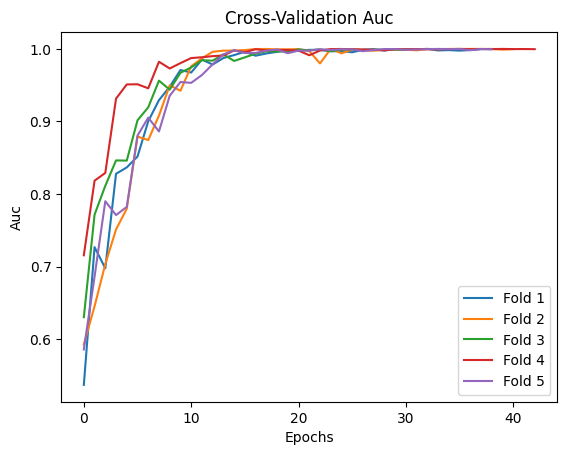

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


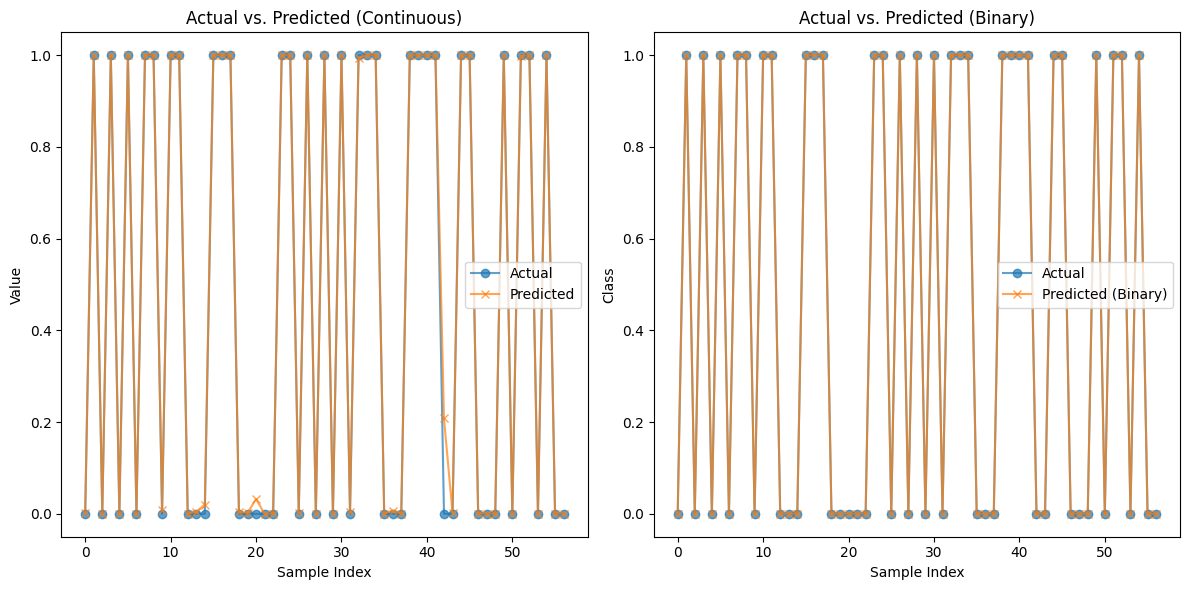

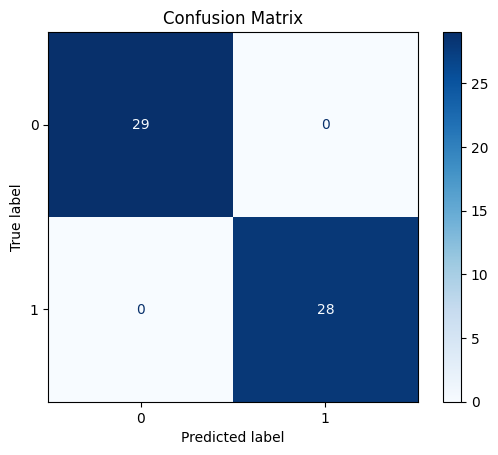

In [13]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Cross-validation loop with metric tracking for plotting
fold_metrics = []
history_per_fold = []  # To store history for each fold
input_shape = (X.shape[1], X.shape[2])  # (time_steps, features)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training Fold {fold + 1}")

    # Split data
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    Y_train_cv, Y_val_cv = Y[train_idx], Y[val_idx]

    # Converting labels to numpy arrays
    Y_train_cv = np.array(Y_train_cv).flatten()
    Y_val_cv = np.array(Y_val_cv).flatten()

    # Building model
    model = create_lstm_model(input_shape)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_cv, Y_train_cv,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_cv, Y_val_cv),
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the history for this fold
    history_per_fold.append(history.history)

    # Evaluate the model
    metrics = model.evaluate(X_val_cv, Y_val_cv, verbose=0)
    fold_metrics.append(dict(zip(model.metrics_names, metrics)))

# Average metrics over all folds
average_metrics = {key: np.mean([fold[key] for fold in fold_metrics]) for key in fold_metrics[0].keys()}
print("Average Metrics Across All Folds:")
print(average_metrics)

# Plot training metrics for all folds
for metric in ['accuracy', 'loss', 'precision', 'recall', 'auc']:
    plt.figure()
    for fold, history in enumerate(history_per_fold):
        if metric in history:  # Ensure the metric is tracked
            plt.plot(history[metric], label=f'Fold {fold + 1}')
    plt.title(f'Cross-Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Predict on the test set
Y_pred = model.predict(X_test).flatten()  # Flatten the predictions to match the shape of actual outputs

# Convert predictions to binary if necessary (threshold at 0.5 for binary classification)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot raw predictions
plt.subplot(1, 2, 1)
plt.plot(Y_test, label="Actual", alpha=0.7, marker='o')
plt.plot(Y_pred, label="Predicted", alpha=0.7, marker='x')
plt.title("Actual vs. Predicted (Continuous)")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()

# Plot binary predictions
plt.subplot(1, 2, 2)
plt.plot(Y_test, label="Actual", alpha=0.7, marker='o')
plt.plot(Y_pred_binary, label="Predicted (Binary)", alpha=0.7, marker='x')
plt.title("Actual vs. Predicted (Binary)")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred_binary)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.5724 - loss: 0.6871 - val_accuracy: 0.5789 - val_loss: 0.6896
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6085 - loss: 0.6884 - val_accuracy: 0.5614 - val_loss: 0.6891
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5655 - loss: 0.6894 - val_accuracy: 0.5614 - val_loss: 0.6886
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5880 - loss: 0.6892 - val_accuracy: 0.5614 - val_loss: 0.6881
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5922 - loss: 0.6854 - val_accuracy: 0.5614 - val_loss: 0.6876
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5616 - loss: 0.6867 - val_accuracy: 0.5614 - val_loss: 0.6872
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6426 - loss: 0.6748 - val_accuracy: 0.5614 - val_loss: 0.6868
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6264 - loss: 0.6835 - val_accuracy: 0.5614 - val_loss

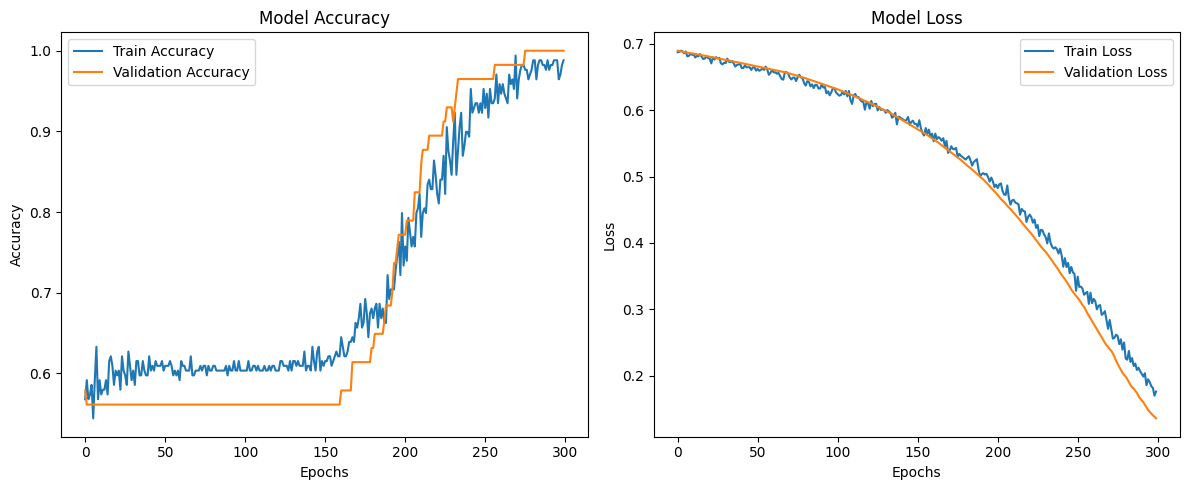

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Assuming X_train, X_validation, X_test, Y_train, Y_validation, Y_test are obtained from split_datasets()

# Ensure the labels (Y) are reshaped for binary classification
Y_train = np.array(Y_train)
Y_validation = np.array(Y_validation)
Y_test = np.array(Y_test)

# Define the GRU model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(128, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))  # Prevent overfitting
    model.add(GRU(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification
    return model

# Get the input shape (time steps, features)
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)

# Build the model
model = create_gru_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_gru_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=300,  # You can adjust based on performance
    batch_size=32,
    validation_data=(X_validation, Y_validation),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy/loss
# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()